Metadata:
frequency: 2450000000.0
sample_rate: 60000000.0
fft_averaging: 3


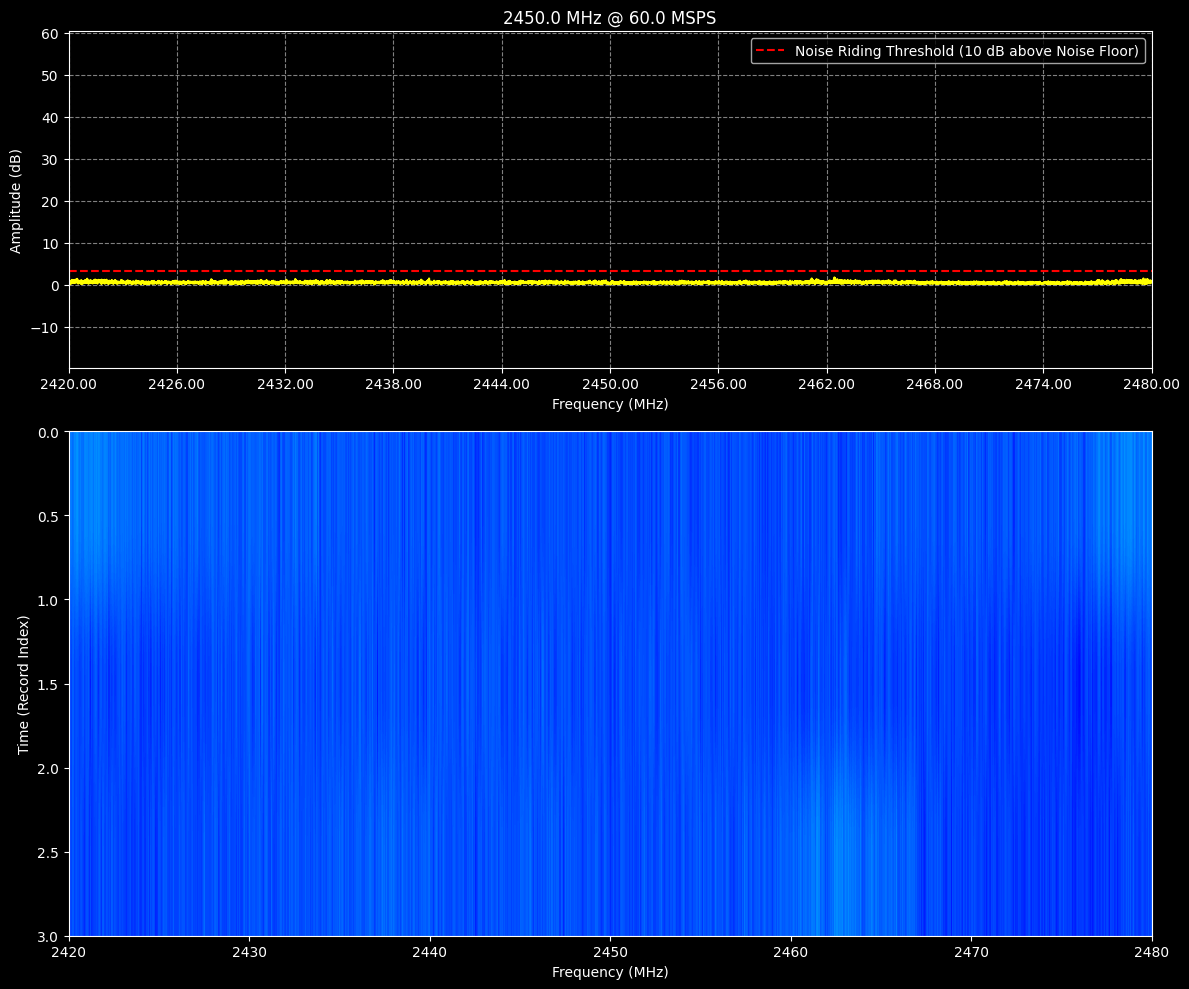


Detected Signals:
Empty DataFrame
Columns: [center_freq, bandwidth, peak_power, avg_power]
Index: []


In [15]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sdr_plot_backend.peak_detector import process_fft_data

# Set the matplotlib theme to dark mode
plt.style.use('dark_background')

# Load the pickle file
# file_path = "/root/datascience/recordings/LTE_20240817_112813.pkl"
file_path = "/root/datascience/recordings/FFT_20240817_16.pkl"
# FFT_20240817_14.pkl
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract metadata and records
metadata = data['metadata']
records = data['records']

# Display metadata
print("Metadata:")
for key, value in metadata.items():
    print(f"{key}: {value}")


def plot_fft_and_waterfall(freq, fft_magnitude, noise_riding_threshold, signals, plot_ranges, freq_bound_left, freq_bound_right, records, metadata):
    """
    Plot the FFT and waterfall data based on the processed information.
    """
    lower_plot_range, upper_plot_range = plot_ranges
    fig, (ax_fft, ax_waterfall) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1.5]})

    # Plot the FFT magnitude spectrum of the averaged FFT data
    ax_fft.plot(freq, fft_magnitude, color='yellow')  # Plot in yellow
    ax_fft.axhline(noise_riding_threshold, color='red', linestyle='--', label="Noise Riding Threshold (10 dB above Noise Floor)")
    ax_fft.set_title(f"{metadata['frequency']/1e6} MHz @ {metadata['sample_rate']/1e6} MSPS")
    ax_fft.set_xlabel("Frequency (MHz)")
    ax_fft.set_ylabel("Amplitude (dB)")
    ax_fft.set_ylim(lower_plot_range, upper_plot_range)
    ax_fft.set_xlim(freq.min(), freq.max())  # Keep x-axis limits based on original FFT frequencies

    # Adjust the x-tick labels to reflect the actual frequency range and ensure 751 MHz is centered
    tick_freqs = np.linspace(freq_bound_left, freq_bound_right, num=11)
    ax_fft.set_xticks(np.linspace(freq.min(), freq.max(), num=11))
    ax_fft.set_xticklabels([f"{f:.2f}" for f in tick_freqs])

    ax_fft.grid(True, color='gray', linestyle='--')

    # Plot vertical lines for each detected signal
    for signal in signals:
        ax_fft.axvline(signal["start_freq"], color='green', linestyle='-', linewidth=1)
        ax_fft.axvline(signal["end_freq"], color='green', linestyle='-', linewidth=1)
        ax_fft.text(signal["center_freq"], upper_plot_range - 10, f"CF: {metadata['frequency']/1e6 + signal['center_freq']:.2f} MHz\nBW: {signal['bandwidth']:.2f} MHz", color='white', ha='center', fontsize=8)

    ax_fft.legend(loc='upper right')

    # Prepare the waterfall data by stacking all FFT records vertically
    waterfall_data = np.vstack([record['fft_magnitude'] for record in records])

    # Plot the waterfall (frequency on X-axis, time on Y-axis)
    extent = [freq_bound_left, freq_bound_right, len(records), 0]  # Swap Y-axis range values to flip the direction
    ax_waterfall.imshow(10 * np.log10(np.abs(waterfall_data)), aspect='auto', extent=extent, cmap='jet', vmin=lower_plot_range, vmax=upper_plot_range)
    ax_waterfall.set_xlabel("Frequency (MHz)")
    ax_waterfall.set_ylabel("Time (Record Index)")

    plt.tight_layout()
    plt.show()

    # Prepare the signals data for the table
    signal_data = {
        "center_freq": [metadata['frequency'] / 1e6 + signal['center_freq'] for signal in signals],
        "bandwidth": [signal['bandwidth'] for signal in signals],
        "peak_power": [signal['peak_power'] for signal in signals],
        "avg_power": [signal['avg_power'] for signal in signals]
    }

    signal_df = pd.DataFrame(signal_data)
    print("\nDetected Signals:")
    print(signal_df)

# Use the function to process FFT data
freq, fft_magnitude, noise_riding_threshold, signals, plot_ranges, freq_bound_left, freq_bound_right = process_fft_data(records, metadata, 3)

# Plot the combined FFT and Waterfall using the processed data
plot_fft_and_waterfall(freq, fft_magnitude, noise_riding_threshold, signals, plot_ranges, freq_bound_left, freq_bound_right, records, metadata)
